## 情感分析项目 

本项目的目标是基于用户提供的评论，通过算法自动去判断其评论是正面的还是负面的情感。比如给定一个用户的评论：
- 评论1： “我特别喜欢这个电器，我已经用了3个月，一点问题都没有！”
- 评论2： “我从这家淘宝店卖的东西不到一周就开始坏掉了，强烈建议不要买，真实浪费钱”

对于这两个评论，第一个明显是正面的，第二个是负面的。 我们希望搭建一个AI算法能够自动帮我们识别出评论是正面还是负面。

情感分析的应用场景非常丰富，也是NLP技术在不同场景中落地的典范。比如对于一个证券领域，作为股民，其实比较关注舆论的变化，这个时候如果能有一个AI算法自动给网络上的舆论做正负面判断，然后把所有相关的结论再整合，这样我们可以根据这些大众的舆论，辅助做买卖的决策。 另外，在电商领域评论无处不在，而且评论已经成为影响用户购买决策的非常重要的因素，所以如果AI系统能够自动分析其情感，则后续可以做很多有意思的应用。 

情感分析是文本处理领域经典的问题。整个系统一般会包括几个模块：
- 数据的抓取： 通过爬虫的技术去网络抓取相关文本数据
- 数据的清洗/预处理：在本文中一般需要去掉无用的信息，比如各种标签（HTML标签），标点符号，停用词等等
- 把文本信息转换成向量： 这也成为特征工程，文本本身是不能作为模型的输入，只有数字（比如向量）才能成为模型的输入。所以进入模型之前，任何的信号都需要转换成模型可识别的数字信号（数字，向量，矩阵，张量...)
- 选择合适的模型以及合适的评估方法。 对于情感分析来说，这是二分类问题（或者三分类：正面，负面，中性），所以需要采用分类算法比如逻辑回归，朴素贝叶斯，神经网络，SVM等等。另外，我们需要选择合适的评估方法，比如对于一个应用，我们是关注准确率呢，还是关注召回率呢？ 

在本次项目中，我们已经给定了训练数据和测试数据，它们分别是 train.positive.txt, train.negative.txt， test_combined.txt. 请注意训练数据和测试数据的格式不一样，详情请见文件内容。 整个项目你需要完成以下步骤：

数据的读取以及清洗： 从给定的.txt中读取内容，并做一些数据清洗，这里需要做几个工作： （1） 文本的读取，需要把字符串内容读进来。 （2）去掉无用的字符比如标点符号，多余的空格，换行符等 （3） 分词
把文本转换成TF-IDF向量： 这部分直接可以利用sklearn提供的TfidfVectorizer类来做。
利用逻辑回归模型来做分类，并通过交叉验证选择最合适的超参数
利用支持向量机做分类，并通过交叉验证选择神经网络的合适的参数

### File Reading: 文本读取

In [105]:
import re

def read_train_file(file_path):
    comments = []  # 用来存储评论
    labels = []   # 存储标签
    with open(file_path) as file:
        # TODO 提取每一个评论，然后利用process_line函数来做处理，并添加到comments。
        text = file.read().replace(' ','').replace('\n','')
        reg = '<reviewid="\d{1,4}">(.*?)</review>'
        result = re.findall(reg,text)
        for r in result:
            comments.append(r)
            if file_path == 'data/train.positive.txt':
                labels.append('1')
            else:
                labels.append('0')
    return comments, labels

def read_test_file(file_path):
    comments = []  # 用来存储评论
    labels = []   # 存储标签
    with open(file_path) as file:
        # TODO 提取每一个评论，然后利用process_line函数来做处理，并添加到comments。
        text = file.read().replace(' ','').replace('\n','')
        reg = '<reviewid="\d{1,4}".*?</review>'
        result = re.findall(reg,text)
        for r in result:
            label_reg = '<reviewid="\d{1,4}"label="(\d)">'
            com_reg = '>(.*?)</review>'
            label = re.findall(label_reg,r)[0]
            comment = re.findall(com_reg,r)[0]
            labels.append(label)
            comments.append(comment)
    return comments, labels
    
        
def process_file():
    """
    读取训练数据和测试数据，并对它们做一些预处理
    """    
    train_pos_file = "data/train.positive.txt"
    train_neg_file = "data/train.negative.txt"
    test_comb_file = "data/test.combined.txt"
    
    # TODO: 读取文件部分，把具体的内容写入到变量里面
    train_pos_comments, train_pos_labels = read_train_file(train_pos_file)
    train_neg_comments, train_neg_labels = read_train_file(train_neg_file)
    test_comments, test_labels = read_test_file(test_comb_file)
    return train_pos_comments, train_pos_labels,train_neg_comments, train_neg_labels,test_comments, test_labels
    
train_pos_comments, train_pos_labels,train_neg_comments, train_neg_labels,test_comments, test_labels = process_file()

### Explorary Analysis: 做一些简单的可视化分析

In [106]:
train_comments = train_pos_comments + train_neg_comments
train_labels = train_pos_labels + train_neg_labels

# 训练数据和测试数据大小
print (len(train_comments), len(test_comments))

8065 2500


Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/1y/y3wkm_bd157fxlr0npb5zv9r0000gn/T/jieba.cache
Loading model cost 1.777 seconds.
Prefix dict has been built succesfully.


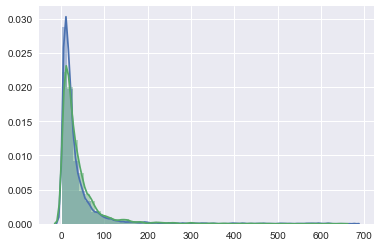

In [107]:
import jieba
import seaborn as sns
%matplotlib inline
# TODO: 对于训练数据中的正负样本，分别画出一个histogram， histogram的x抽是每一个样本中字符串的长度，y轴是拥有这个长度的样本的百分比。
#       并说出样本长度是否对情感有相关性 (需要先用到结巴分词)
#       参考：https://en.wikipedia.org/wiki/Histogram
def count_sentence(sentences):
    len_list = []
    for s in sentences:
        sentence = []
        for i in jieba.cut(s):
            sentence.append(i)
        len_list.append(len(sentence))
    return len_list


sns.distplot(count_sentence(train_pos_comments))   # train_pos_comments样本中各长度样本所占百分比
sns.distplot(count_sentence(train_neg_comments))   # train_neg_comments样本中各长度样本所占百分比

# 右下图中可以观察到，正负样本的长度所占百分比的趋势基本接近，说明样本长度与情感没有相关性

In [109]:
import collections

# TODO： 分别列出训练数据中正负样本里的top 20单词（可以做适当的stop words removal）。 
def get_top20_words(comments):
    word_library = []   # 储存所有词
    for comment in comments:
        for i in jieba.cut(comment):
            word_library.append(i)
    word_dic = collections.Counter(word_library).most_common(20)
    top20_list = [i[0] for i in word_dic]
    return top20_list

print(get_top20_words(train_pos_comments))
print(get_top20_words(train_neg_comments))    

['，', '的', '。', '了', '是', '！', '很', ',', '我', '也', '在', '有', '~', '都', '好', '.', '不错', '就', '买', '喜欢']
['，', '的', '。', '了', '！', '是', '我', ',', '不', '买', '就', '也', '都', '很', '有', '在', '？', '没有', '!', '.']


In [110]:
# 根据正负样本里的top 20单词，手动生成停用词库
stop_words = ['的','了','是','很','我','也','在','买','有','都','就']

### Text Cleaning: 文本处理部分

In [111]:
import string
# TODO：对于train_comments, test_comments进行字符串的处理，几个考虑的点：
#   1. 停用词过滤
#   2. 去掉特殊符号
#   3. 去掉数字（比如价格..)
#   4. ...
#   需要注意的点是，由于评论数据本身很短，如果去掉的太多，很可能字符串长度变成0
#   预处理部部分，可以自行选择合适的方案，只要注释就可以。
def text_preprocessing(comments):
    comments_new = []
    for comment in comments:
        sentence = ''
        for word in list(jieba.cut(comment)):
            # 去除停用词、标点符号、数字
            if word not in set(stop_words) and word.isalnum() and not word.isdigit():
                sentence += word + ' '
        comments_new.append(sentence)
    return comments_new
    
train_comments_new = text_preprocessing(train_comments)
test_comments_new = text_preprocessing(test_comments)


### Feature Extraction : 从文本中提取特征

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
# TODO: 利用tf-idf从文本中提取特征,写到数组里面. 
#       参考：https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
tfid_vec = TfidfVectorizer()
X_train = tfid_vec.fit_transform(train_comments)
y_train = np.array(train_labels)
X_test = tfid_vec.transform(test_comments)
y_test = np.array(test_labels)

print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(8065, 43903) (2500, 43903) (8065,) (2500,)


### Modeling: 训练模型以及选择合适的超参数

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# TODO： 利用逻辑回归来训练模型
#       1. 评估方式： F1-score
#       2. 超参数（hyperparater）的选择利用grid search https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#       3. 打印出在测试数据中的最好的结果（precision, recall, f1-score, 需要分别打印出正负样本，以及综合的）
#       请注意：做交叉验证时绝对不能用测试数据。 测试数据只能用来最后的”一次性“检验。
#       逻辑回归的使用方法请参考：http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
#       对于逻辑回归，经常调整的超参数为： C
 
parameters = { 'C':np.logspace(-3,3,7)}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
y_predict = clf.predict(X_test)
print(classification_report(y_test, y_predict))


{'C': 1000.0}
             precision    recall  f1-score   support

          0       0.75      0.17      0.28      1250
          1       0.53      0.94      0.68      1250

avg / total       0.64      0.56      0.48      2500



In [12]:
from sklearn import svm
# TODO： 利用SVM来训练模型
#       1. 评估方式： F1-score
#       2. 超参数（hyperparater）的选择利用grid search https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#       3. 打印出在测试数据中的最好的结果（precision, recall, f1-score, 需要分别打印出正负样本，以及综合的）
#       请注意：做交叉验证时绝对不能用测试数据。 测试数据只能用来最后的”一次性“检验。
#       SVM的使用方法请参考：http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#       对于SVM模型，经常调整的超参数为：C, gamma, kernel

parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':np.logspace(-3,3,7)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
y_predict = clf.predict(X_test)
print(classification_report(y_test, y_predict))

{'C': 10.0, 'kernel': 'linear'}
             precision    recall  f1-score   support

          0       0.77      0.17      0.28      1250
          1       0.53      0.95      0.68      1250

avg / total       0.65      0.56      0.48      2500



对于超参数的调整，我们经常使用gridsearch，这也是工业界最常用的方法，但它的缺点是需要大量的计算，所以近年来这方面的研究也成为了重点。 其中一个比较经典的成果为Bayesian Optimization（利用贝叶斯的思路去寻找最好的超参数）。Ryan P. Adams主导的Bayesian Optimization利用高斯过程作为后验概率（posteior distribution）来寻找最优解。 https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf 在下面的练习中，我们尝试使用Bayesian Optimization工具来去寻找最优的超参数。参考工具：https://github.com/fmfn/BayesianOptimization

In [135]:
# TODO: 仍然使用SVM模型，但在这里使用Bayesian Optimization来寻找最好的超参数。 
#       1. 评估方式： F1-score
#       2. 超参数（hyperparater）的选择利用Bayesian Optimization https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#       3. 打印出在测试数据中的最好的结果（precision, recall, f1-score, 需要分别打印出正负样本，以及综合的）
#       请注意：做交叉验证时绝对不能用测试数据。 测试数据只能用来最后的”一次性“检验。
#       SVM的使用方法请参考：http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#       对于SVM模型，经常调整的超参数为：C, gamma, kernel
#       参考Bayesian Optimization开源工具： https://github.com/fmfn/BayesianOptimization


from sklearn.cross_validation import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.svm import SVC

In [136]:
def svm_cv(C, gamma):
    svm = SVC(C=10 ** C, gamma=10 ** gamma,random_state=1)
    val = cross_val_score(svm,X_train, y_train, cv=5).mean()
    return val

In [137]:
pbounds = {'C':(0,1),'gamma':(2,20)}
svm_bo = BayesianOptimization(svm_cv,pbounds=pbounds)

In [138]:
svm_bo.maximize()


|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.6196   |  0.5383   |  17.17    |
|  2        |  0.6196   |  0.03277  |  11.02    |
|  3        |  0.6196   |  0.391    |  18.42    |
|  4        |  0.6196   |  0.6569   |  7.471    |
|  5        |  0.6196   |  0.814    |  12.38    |
|  6        |  0.6196   |  0.01734  |  2.001    |
|  7        |  0.6196   |  0.2771   |  2.024    |
|  8        |  0.6196   |  0.5181   |  19.96    |
|  9        |  0.6196   |  0.5492   |  2.058    |
|  10       |  0.6196   |  0.7518   |  19.91    |
|  11       |  0.6196   |  0.05667  |  2.061    |
|  12       |  0.6196   |  0.313    |  19.9     |
|  13       |  0.6196   |  0.07876  |  2.006    |
|  14       |  0.6196   |  0.2191   |  19.99    |
|  15       |  0.6196   |  0.6871   |  2.068    |
|  16       |  0.6196   |  0.2401   |  19.93    |
|  17       |  0.6196   |  0.4216   |  2.095    |
|  18       |  0.6196   |  0.3158   |  19.84    |
